# Import 

In [20]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


# 데이터 불러오기 & 전처리

In [3]:
# 데이터 불러오기
cancer = load_breast_cancer() # 유방암 데이터 불러오기
x = cancer.data # 입력 값 
y = cancer.target # 출력 값

In [4]:
#전체 데이터를 훈련 데이터랑 최후의 테스트 데이터로 나눔 
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)

# 훈련 데이터를 훈련 데이터랑 검증 데이터로 나눔 
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [5]:
# 훈련 세트와 검증 세트의 크기 확인
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [21]:
scaler = StandardScaler()
scaler.fit(x_train)
# scaler로 평균이 0, 표준 편차가 1인 데이터셋으로 변환
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

# 모델 클래스

In [39]:
# 단일 레이어
class SingleLayer:
    def __init__(self, learning_rate = 0.1, l1=0, l2=0):
        self.w = None # 가중치
        self.b = None # 절편
        self.losses = [] # 훈련 데이터에 대한 손실
        self.val_losses = [] # 검증 데이터에 대한 손실
        self.w_history = [] # 가중치 기록
        self.lr = learning_rate # 학습률(내가 따로 지정하는거)
        self.l1 = l1 # L1손실 하이퍼 파라미터
        self.l2 = l2 # L2손실 하이퍼 파라미터

    def forpass(self,x): # 정방향 계산
        z = np.dot(x, self.w) + self.b # 예측값 계산(입력 데이터 * 가중치 + 절편)
        return z

    def backprop(self, x, err): # 역방향 계산
        m = len(x) # 그래디언트 크기. len() : 넘파이 배열의 행 크기 반환.
        w_grad = np.dot(x.T, err) / m # 가중치에 대한 평균 그래디언트
        b_grad = np.sum(err)/m # 절편에 대한 평균 그래디언트
        return w_grad, b_grad
    
    def activation(self, z): # 예측값을 0~1 사이의 값으로 만들어버림.
        a = 1/ (1+ np.exp(-z)) # 시그모이드 계산
        return a

    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 행렬 연산을 위해 변환
        y = y.reshape(-1,1) # 열 벡터로 바꿈([ㅁ ㅁ ㅁ ㅁ]^T)
        y_val = y_val.reshape(-1,1) # 열 벡터로 바꿈
        m = len(x)
        #가중치, 절편 초기값 설정
        self.w = np.ones((x.shape[1],1)) # 가중치 초기화([1,1,1]^T)
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중치 기록

        # 에포크만큼 반복
        for i in range(epochs):
            z = self.forpass(x) # 예측값 
            a = self.activation(z) # 활성화 함수
            err = -(y-a) #실제 값 - 예측값 = 오차
            #오차를 역전파하여 그래디언트 계산
            w_grad, b_grad = self.backprop(x, err)
            #그래디언트에서 페널티 항의 미분값을 더함
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m # L1규제, L2규제를 적용해 그래디언트 계산
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            #가중치 기록
            self.w_history.append(self.w.copy())
            # 클리핑(역전파 과정에서 그래디언트가 비정상적으로 작아지거나 커지는거 방지)
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss+self.reg_loss())/m) # 평균 손실
            # 검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)

    def predict(self,x):
        z = self.forpass(x)
        return z>0
    
    def score(self, x, y):
        # 예측값, 타깃 값 비교해 True의 비율 반환
        return np.mean(self.predict(x) == y.reshape(-1,1))
    
    def reg_loss(self):
        # 가중치에 규제 적용
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

    # 검증 세트에 대한 손실 계산
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val) # 정방향 계산
        a = self.activation(z) # 활성화 함수
        a = np.clip(a, 1e-10, 1-1e-10) # 활성화 함수 클리핑
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.losses.append((val_loss+self.reg_loss())/ len(y_val)) # 평균 손실

In [41]:
single_layer = SingleLayer(l2 = 0.01) # l2규제를 적용한 단일 레이어 객체 생성
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val = y_val, epochs = 10000) # 훈련
# 배치 경사 하강법은 한번에 계산하기 때문에 확률적 경사 하강법보다 에포크 횟수를 많이 늘려야함
single_layer.score(x_val_scaled, y_val) # 점수 계산

0.978021978021978

# 성능 측정

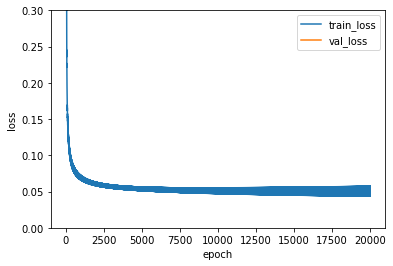

In [42]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 전체 샘플을 사용해 가중치 업데이트 -> 손실값이 안정적으로 감소

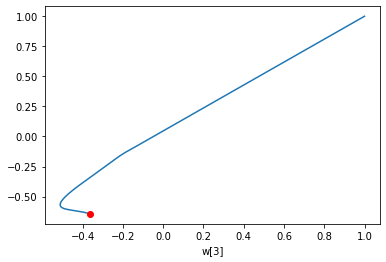

In [46]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro') # 'ro' : 빨간색으로 동그란 원. -1은 마지막 위치를 뜻함
plt.xlabel('w[2]')
plt.xlabel('w[3]')
plt.show()

# 가중치의 변화가 연속적이기 때문에 부드러운 곡선을 그리며 최종 가중치를 발견.